# Guide for dealing with problem definition

In [1]:
import warnings
import sys 

import pandas as pd
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
from pydts.fitters import TwoStagesFitter

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 25)
warnings.filterwarnings('ignore')
%matplotlib inline

## Case study #1: Not enough cases in the tail

<b>For the first example we would consider settings in which the cases are becoming less frequent in the tail end of the data </b>

In [2]:
df = generate_quick_start_df(n_patients=1000, n_cov=5, d_times=30, j_events=2, pid_col='pid', seed=0)

(df.groupby(['J'])['X'].value_counts()).to_frame().unstack()

X                                                                    \
X    1     2     3     4     5     6     7     8     9     10    11    12   
J                                                                           
0  24.0  25.0  25.0  24.0  19.0  19.0  22.0  17.0  23.0  20.0  15.0  16.0   
1  74.0  41.0  36.0  33.0  21.0  25.0  20.0  13.0  11.0  13.0  10.0  10.0   
2  29.0  11.0  19.0  15.0  17.0   4.0   7.0   6.0   8.0   7.0  11.0   3.0   

   ...                                                                      
X  ...    19    20    21    22    23    24    25   26   27    28   29   30  
J  ...                                                                      
0  ...  16.0  13.0  20.0  13.0  14.0  14.0  12.0  9.0  7.0  11.0  6.0  9.0  
1  ...   2.0   4.0   2.0   5.0   1.0   6.0   1.0  2.0  1.0   2.0  NaN  1.0  
2  ...   1.0   1.0   1.0   1.0   1.0   1.0   1.0  NaN  NaN   NaN  NaN  1.0  

[3 rows x 30 columns]

In [3]:
m2 = TwoStagesFitter()
try:
    m2.fit(df.drop(columns=['C', 'T']),verbose=0)
except RuntimeError as e:
    raise e.with_traceback(None)

RuntimeError: In event J=1, The method didn't have events D=[29]. Consider changing the problem definition. 
 See TBD for more details.

<b> In this case we see that the method doesn't have events for D=29. let's see the distrubtion: </b>

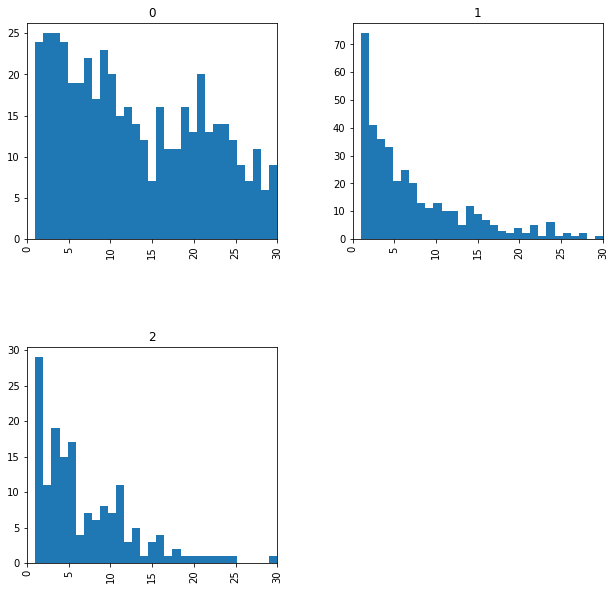

In [4]:
axes = df.hist(column=['X'], by=['J'], bins=30, figsize=(10,10))
for ax in axes.flatten():
    ax.set_xlim(0, 30)

As one can easily see from the data, We don't have events during the 25-30 days. \
for example - we can think about a patients length of stay in hospital - patints are more likely to stay in hospital or to leave hospital soon after hospitalization, but only few are leaving after it.\
To tackle this challenge, we can induce adminstrative censorship, such that patients that had event (either $J=1$ or $J=2$) after the 25th day (25+), is considered to be similar to patient that had event in the 25th day.

In [5]:
temp_df = df.copy() # so we don't change the original data
temp_df['X'].clip(upper=25, inplace=True ) # we are clipping all the patients over 25 days to 25
m2 = TwoStagesFitter()
m2.fit(temp_df.drop(columns=['C', 'T']))
m2.print_summary()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Model summary for event: 1


<lifelines.CoxPHFitter: fitted with 9560 total observations, 9185 right-censored observations>
             duration col = 'X'
                event col = 'j_1'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 9560
number of events observed = 375
   partial log-likelihood = -2313.33
         time fit was run = 2022-03-22 16:13:49 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1          0.09       1.09       0.18            -0.26             0.44                 0.77                 1.56
Z2         -1.04       0.35       0.18            -1.41            -0.68                 0.24                 0.51
Z3         -1.07       0.34       0.19            -1.44            -0.71                 0.24                 0.49
Z4         -0.53       0.59       0.17            -0.88            -0.19                 0.42                 0.82
Z5         -0.52       0.59       0.18            -0.87            -0.18                 0.42                 0.84

              z      p   -log2(p)
covariate                        
Z1         0.50   0.62       0.70
Z2        -5.65 <0.005      25.93
Z3        -5.81 <0.005      27.26
Z4        -3.08 <0.005       8.91
Z5        -2.98 <0.005       8.46
---
Concordance = 0.63
Partial AIC = 4636.66
log-likelihood ratio test = 81.75 on 5 df
-log2(p) of ll-ratio test = 51.30

n_jt  success  alpha_jt
J X                          
1 1     74     True -1.095820
  2     41     True -1.564119
  3     36     True -1.580492
  4     33     True -1.542081
  5     21     True -1.896471
  6     25     True -1.598934
  7     20     True -1.737360
  8     13     True -2.066961
  9     11     True -2.135509
  10    13     True -1.859094
  11    10     True -2.002466
  12    10     True -1.879609
  13     5     True -2.486454
  14    12     True -1.501572
  15     9     True -1.703977
  16     7     True -1.856787
  17     5     True -2.067510
  18     3     True -2.482490
  19     2     True -2.806679
  20     4     True -1.998939
  21     2     True -2.568323
  22     5     True -1.487019
  23     1     True -2.914662
  24     6     True -0.859760
  25     7     True -0.335299



Model summary for event: 2


<lifelines.CoxPHFitter: fitted with 9560 total observations, 9399 right-censored observations>
             duration col = 'X'
                event col = 'j_2'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 9560
number of events observed = 161
   partial log-likelihood = -987.17
         time fit was run = 2022-03-22 16:13:50 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1          0.17       1.18       0.27            -0.37             0.71                 0.69                 2.02
Z2         -1.08       0.34       0.28            -1.63            -0.53                 0.20                 0.59
Z3         -1.67       0.19       0.29            -2.24            -1.10                 0.11                 0.33
Z4         -0.67       0.51       0.27            -1.19            -0.15                 0.30                 0.86
Z5         -0.38       0.69       0.27            -0.90             0.15                 0.41                 1.16

              z      p   -log2(p)
covariate                        
Z1         0.61   0.54       0.89
Z2        -3.85 <0.005      13.03
Z3        -5.73 <0.005      26.59
Z4        -2.53   0.01       6.46
Z5        -1.41   0.16       2.66
---
Concordance = 0.66
Partial AIC = 1984.33
log-likelihood ratio test = 56.08 on 5 df
-log2(p) of ll-ratio test = 33.57

n_jt  success  alpha_jt
J X                          
2 1     29     True -1.889441
  2     11     True -2.713222
  3     19     True -2.027058
  4     15     True -2.141383
  5     17     True -1.889341
  6      4     True -3.162640
  7      7     True -2.589820
  8      6     True -2.631269
  9      8     True -2.229403
  10     7     True -2.257762
  11    11     True -1.664896
  12     3     True -2.836411
  13     5     True -2.246092
  14     1     True -3.607395
  15     3     True -2.582261
  16     4     True -2.176043
  17     1     True -3.368219
  18     2     True -2.626271
  19     1     True -3.202843
  20     1     True -3.042474
  21     1     True -2.958991
  22     1     True -2.840443
  23     1     True -2.655788
  24     1     True -2.408854
  25     2     True -1.382297

Now, we can predict the surviavl curves for patients that had events ($J\in\{1,2\}$) in days 1-24 or in day 25 and after.

## Case study #2: Not enough cases in the middle

In this example we examine a case where there is no events during the weekend, but only cencoreship.
This use-case shows possible solution of combining those events into stucks of "weekend".

In [6]:
(temp_df.groupby(['J'])['X'].value_counts()).to_frame().unstack()

X                                                                         \
X  1   2   3   4   5   6   7   8   9   10  11  12  13  14 15  16  17  18  19   
J                                                                              
0  24  25  25  24  19  19  22  17  23  20  15  16  14  12  7  16  11  11  16   
1  74  41  36  33  21  25  20  13  11  13  10  10   5  12  9   7   5   3   2   
2  29  11  19  15  17   4   7   6   8   7  11   3   5   1  3   4   1   2   1   

                           
X  20  21  22  23  24  25  
J                          
0  13  20  13  14  14  54  
1   4   2   5   1   6   7  
2   1   1   1   1   1   2

In [7]:
def map_days(row):
    if row['X'] in [7, 14, 21] and row['J'] in [1,2]:
        row['X'] -= 1
        row['X'].astype(int)
    return row

temp_df = temp_df.apply(map_days, axis=1)
temp_df[['J', 'T', 'C', 'X']] = temp_df[['J', 'T', 'C', 'X']].astype('int64')

<b> As expected in this case, the fitter is falied to converage, because it lacks events in days 7,14,21 ("The weekend") </b>

In [8]:
m2 = TwoStagesFitter()
try: 
    m2.fit(temp_df.drop(columns=['C', 'T']), verbose=0)
except RuntimeError as e:
    raise e.with_traceback(None)

RuntimeError: In event J=1, The method didn't have events D=[7, 14, 21]. Consider changing the problem definition. 
 See TBD for more details.

<b> And we get error as expected </b>

Further exploring the disribution, we notice that we have a "hole" during the weekends, so we need do fix this behavior

X                                                                    \
X    1     2     3     4     5     6     7     8     9     10    11    12   
J                                                                           
0  24.0  25.0  25.0  24.0  19.0  19.0  22.0  17.0  23.0  20.0  15.0  16.0   
1  74.0  41.0  36.0  33.0  21.0  45.0   NaN  13.0  11.0  13.0  10.0  10.0   
2  29.0  11.0  19.0  15.0  17.0  11.0   NaN   6.0   8.0   7.0  11.0   3.0   

                                                                                
X    13    14   15    16    17    18    19    20    21    22    23    24    25  
J                                                                               
0  14.0  12.0  7.0  16.0  11.0  11.0  16.0  13.0  20.0  13.0  14.0  14.0  54.0  
1  17.0   NaN  9.0   7.0   5.0   3.0   2.0   6.0   NaN   5.0   1.0   6.0   7.0  
2   6.0   NaN  3.0   4.0   1.0   2.0   1.0   2.0   NaN   1.0   1.0   1.0   2.0

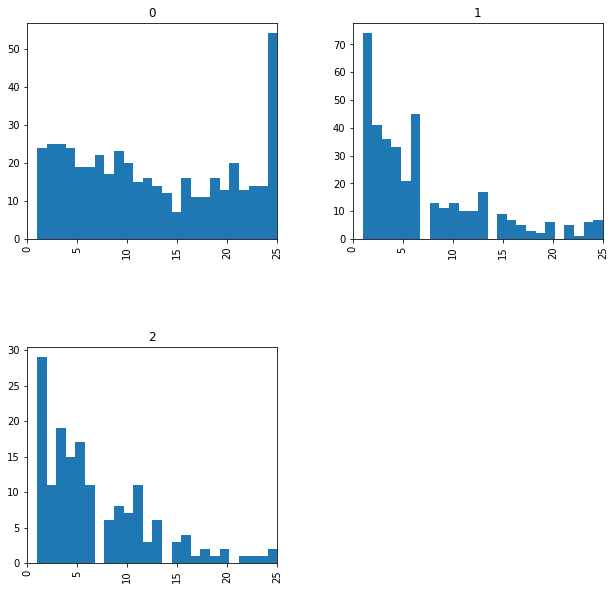

In [9]:
display((temp_df.groupby(['J'])['X'].value_counts()).to_frame().unstack())

axes = temp_df.hist(column=['X'], by=['J'], bins=25, figsize=(10,10))
for ax in axes.flatten():
    ax.set_xlim(0, 25)

One of such fixes can be stacking the events which occurs during the weekend, as one "bucket". 

In [10]:
def map_days_second_try(row):
    if row['X'] in [7, 14, 21] and row['J'] == 0:
        row['X'] -= 1
        row['X'].astype(int)
    return row

temp_df = temp_df.apply(map_days_second_try, axis=1)
temp_df[['J', 'T', 'C', 'X']] = temp_df[['J', 'T', 'C', 'X']].astype('int64')

X                                                                         \
X  1   2   3   4   5   6   8   9   10  11  12  13 15  16  17  18  19  20  22   
J                                                                              
0  24  25  25  24  19  41  17  23  20  15  16  26  7  16  11  11  16  33  13   
1  74  41  36  33  21  45  13  11  13  10  10  17  9   7   5   3   2   6   5   
2  29  11  19  15  17  11   6   8   7  11   3   6  3   4   1   2   1   2   1   

               
X  23  24  25  
J              
0  14  14  54  
1   1   6   7  
2   1   1   2

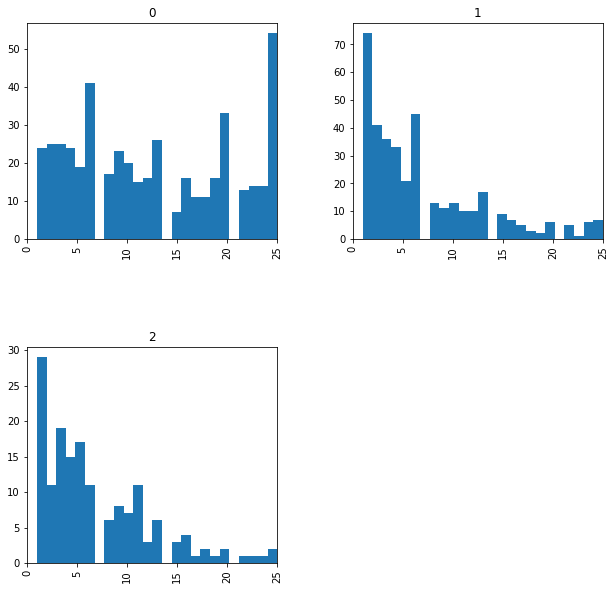

In [11]:
display((temp_df.groupby(['J'])['X'].value_counts()).to_frame().unstack())

axes = temp_df.hist(column=['X'], by=['J'], bins=25, figsize=(10,10))
for ax in axes.flatten():
    ax.set_xlim(0, 25)

Now, we can our fit would work as planned, and the model provides $\alpha$ only for the times we provided. \
Thus, we should note our model can't predict during those days.

In [12]:
m2 = TwoStagesFitter()
m2.fit(temp_df.drop(columns=['C', 'T']), verbose=0)
m2.print_summary()



Model summary for event: 1


<lifelines.CoxPHFitter: fitted with 9463 total observations, 9088 right-censored observations>
             duration col = 'X'
                event col = 'j_1'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 9463
number of events observed = 375
   partial log-likelihood = -2315.15
         time fit was run = 2022-03-22 16:14:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1          0.09       1.09       0.18            -0.27             0.44                 0.76                 1.55
Z2         -1.04       0.35       0.18            -1.41            -0.68                 0.25                 0.51
Z3         -1.08       0.34       0.18            -1.44            -0.72                 0.24                 0.49
Z4         -0.53       0.59       0.17            -0.87            -0.19                 0.42                 0.83
Z5         -0.52       0.59       0.18            -0.86            -0.18                 0.42                 0.84

              z      p   -log2(p)
covariate                        
Z1         0.48   0.63       0.66
Z2        -5.65 <0.005      25.87
Z3        -5.84 <0.005      27.49
Z4        -3.06 <0.005       8.82
Z5        -2.96 <0.005       8.37
---
Concordance = 0.63
Partial AIC = 4640.29
log-likelihood ratio test = 81.78 on 5 df
-log2(p) of ll-ratio test = 51.32

n_jt  success  alpha_jt
J X                          
1 1     74     True -1.095262
  2     41     True -1.563535
  3     36     True -1.579912
  4     33     True -1.541470
  5     21     True -1.895841
  6     45     True -0.967645
  8     13     True -2.066400
  9     11     True -2.134931
  10    13     True -1.858564
  11    10     True -2.001975
  12    10     True -1.879093
  13    17     True -1.223394
  15     9     True -1.703488
  16     7     True -1.856321
  17     5     True -2.067005
  18     3     True -2.481967
  19     2     True -2.806130
  20     6     True -1.579369
  22     5     True -1.486437
  23     1     True -2.914180
  24     6     True -0.859284
  25     7     True -0.334542



Model summary for event: 2


<lifelines.CoxPHFitter: fitted with 9463 total observations, 9302 right-censored observations>
             duration col = 'X'
                event col = 'j_2'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 9463
number of events observed = 161
   partial log-likelihood = -987.94
         time fit was run = 2022-03-22 16:14:20 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1          0.16       1.18       0.27            -0.37             0.70                 0.69                 2.02
Z2         -1.08       0.34       0.28            -1.63            -0.53                 0.20                 0.59
Z3         -1.67       0.19       0.29            -2.24            -1.10                 0.11                 0.33
Z4         -0.67       0.51       0.27            -1.19            -0.15                 0.31                 0.86
Z5         -0.38       0.69       0.27            -0.90             0.15                 0.41                 1.16

              z      p   -log2(p)
covariate                        
Z1         0.60   0.55       0.87
Z2        -3.83 <0.005      12.92
Z3        -5.74 <0.005      26.68
Z4        -2.52   0.01       6.39
Z5        -1.40   0.16       2.64
---
Concordance = 0.66
Partial AIC = 1985.88
log-likelihood ratio test = 55.99 on 5 df
-log2(p) of ll-ratio test = 33.51

n_jt  success  alpha_jt
J X                          
2 1     29     True -1.891318
  2     11     True -2.715119
  3     19     True -2.029019
  4     15     True -2.143387
  5     17     True -1.891328
  6     11     True -2.224464
  8      6     True -2.633376
  9      8     True -2.231573
  10     7     True -2.259989
  11    11     True -1.667235
  12     3     True -2.838670
  13     6     True -2.067073
  15     3     True -2.584596
  16     4     True -2.178489
  17     1     True -3.370445
  18     2     True -2.628716
  19     1     True -3.205144
  20     2     True -2.415453
  22     1     True -2.842736
  23     1     True -2.658322
  24     1     True -2.411368
  25     2     True -1.384788